In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

2024-03-31 20:50:51.093911: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **Persona 1 SMOTE/RF/SVM/NN**

In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load dataset
data = pd.read_csv('bank-additional-full.csv', delimiter=';')
#Calculate the nulls and then drop them
print(data.isnull().sum())
#vv Comment out below this line to see the total nulls for each column vv
data = data.dropna()
data.info()
print(data.isnull().sum())
data = data.drop_duplicates()
data

# Since SMOTE works with numeric data, we need to convert categorical variables into dummy/indicator variables
data_dummy = pd.get_dummies(data.drop('y', axis=1))

# Encode target variable
data['y'] = data['y'].map({'no': 0, 'yes': 1})

# Split data into features and target
X = data_dummy[['marital_married', 'job_self-employed', 'education_university.degree', 'loan_yes', 'age', 'housing_yes']]
y = data['y']

# It's generally a good idea to scale the features before applying SMOTE, as distance-based algorithms can be sensitive to the scale of the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training and testing set to demonstrate how SMOTE should be applied only to the training set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Applying SMOTE to the training data
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Checking the class distribution after applying SMOTE
balanced_data_check = pd.Series(y_res).value_counts()

balanced_data_check

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   mon

y
0    25608
1    25608
Name: count, dtype: int64

In [11]:
# Random Forest - Fine tuning with GridSearchCV
# using datetime to time the fine tuning process
from datetime import datetime
print("Start search time:", datetime.now())

from sklearn.ensemble import RandomForestClassifier

# find the best parameters
from sklearn.model_selection import GridSearchCV

# RF -- Tunning parameters
# Define the parameter grid
param = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at every split
    'max_depth': [4, 6, 8],  # Maximum number of levels in tree
    'criterion': ['gini', 'entropy']  # Function to measure the quality of a split
}

RF = RandomForestClassifier(random_state=10)

# search parameters: cv=cross validation blocks; verbose=higher value show more steps
# n_jobs=-1 uses all available CPU cores;
grid = GridSearchCV(estimator=RF,
                    param_grid=param,
                    scoring="accuracy",
                    verbose=1, cv=5)

grid.fit(X_res, y_res)

print("Best parameters:", grid.best_params_)

print("Best estimator:", grid.best_estimator_)

print("Feature importance:", grid.best_estimator_.feature_importances_)

# end grid search
print("End search time:", datetime.now())

Start search time: 2024-03-31 20:52:53.215315
Fitting 5 folds for each of 36 candidates, totalling 180 fits



Accuracy: 0.8875940762320952
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10968
           1       0.00      0.00      0.00      1389

    accuracy                           0.89     12357
   macro avg       0.44      0.50      0.47     12357
weighted avg       0.79      0.89      0.83     12357



/Users/jakebrulato/Documents/GitHub/6156-Machine_Learning/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakebrulato/Documents/GitHub/6156-Machine_Learning/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakebrulato/Documents/GitHub/6156-Machine_Learning/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

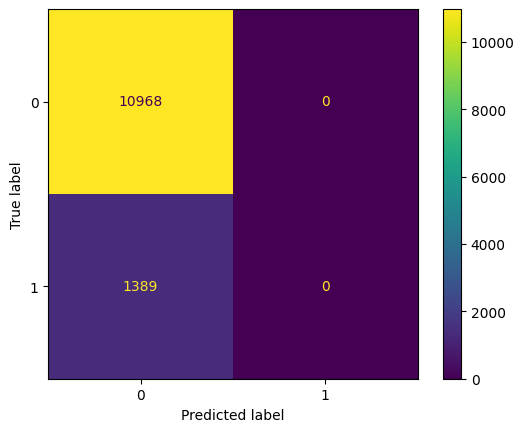

In [6]:
import sklearn.metrics as metrics
# confusion matrix

final_model_rf = grid.best_estimator_

y_pred = final_model_rf.predict(X_test)

# get accuracy and confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)
report = classification_report(y_test, y_pred)
print(report)


cm = metrics.confusion_matrix(y_test,y_pred) # row - true value; column - predicted
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()

## SVM

In [9]:
# SVM - Fine tuning with GridSearchCV
# using datetime to time the fine tuning process
from datetime import datetime
print("Start search time:", datetime.now())

# find the best parameters
from sklearn.model_selection import GridSearchCV

# SVM -- Tunning parameters
param = {
    'C':[.00001, .0001, .001, 0.01],
    'gamma': [.00001, .0001, .001, .01], # 1/n_features
    'kernel': ['rbf','linear']
}

SVM = SVC(random_state=10)


# search parameters: cv=cross validation blocks; verbose=higher value show more steps
# n_jobs=-1 uses all available CPU cores;
grid = GridSearchCV(estimator= SVM,
                    param_grid=param,
                    verbose=3, cv=3,
                    refit=True)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

print("Best estimator:", grid.best_estimator_)

# end grid search
print("End search time:", datetime.now())

Start search time: 2024-03-31 20:51:13.008589


NameError: name 'SVC' is not defined

In [ ]:
# confusion matrix

final_model_svm = grid.best_estimator_

y_pred = final_model_svm.predict(X_test_JB)

# get accuracy and confusion matrix
accuracy = metrics.accuracy_score(y_test_JB, y_pred)
print("\nAccuracy:", accuracy)
report = classification_report(y_test, y_pred)
print(report)

cm = metrics.confusion_matrix(y_test_JB,y_pred) # row - true value; column - predicted
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()
# disp.plot()
plt.show() # display all open figures

## RNN

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
bank_df = pd.read_csv('bank-additional-full.csv', sep=';')

# For the demonstration, let's select 'age' and 'duration' as features
features = X
target = y

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
import torch

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Adding a singleton dimension for labels
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [ ]:
# Define a neural network without activation function
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        # self.fc = nn.Linear(3, 2)  # Linear layer 1
        # self.fc = nn.Linear(2, 1) #Linear layer 1
        self.fc1 = nn.Linear(2, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x
        # return self.fc(x)

# Define a neural network with activation function
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 8)  # Linear layer
        self.activation = nn.ReLU()       # Activation function (ReLU)-
        self.fc2 = nn.Linear(8, 1)  # Linear layer

    def forward(self, x):
        x = self.activation(self.fc1(x))  # Activation function (ReLU) after first layer
        x = self.fc2(x)
        return x

print("Linear Model")
model = LinearModel()
print(model)
print("Neural Network")
model = NeuralNetwork()
print(model)

In [ ]:
# Train the model
def train(model, criterion, optimizer, X, y, epochs=1000):
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()


def plot_decision_boundary(X, y, model, title):
    X = X.numpy()
    y = y.numpy().squeeze()  # Squeeze the y tensor to remove extra dimension
    plt.scatter(X[y==0][:,0], X[y==0][:,1], color='blue', label='Class 0') #data points of class=0
    plt.scatter(X[y==1][:,0], X[y==1][:,1], color='red', label='Class 1') #data points of class=1

    # Creating a meshgrid for all the possible values of features
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 #Padding of 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100)) #Create 100*100 meshgrid points evenly spaced between x_max x_min for x-axis and y_max,y_min for y_axis
    X_grid = np.c_[xx.ravel(), yy.ravel()] #Flattens the dataset.

    print('X_grid')
    display(X_grid)


    # Predict the class for each meshgrid point
    Z = model(torch.tensor(X_grid, dtype=torch.float32)).detach().numpy().reshape(xx.shape)
    # Plot the decision boundary using contour lines
    plt.contour(xx, yy, Z,colors='green', linestyles='dashed', linewidths=2,MaxNLocator=0,levels=0) #Connects the point where the probabilities for (class 0 and class 1) are equal giving us contours

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.show()

In [ ]:
# Create models, criterion, and optimizer
linear_model = LinearModel()
neural_network = NeuralNetwork()
criterion = nn.BCEWithLogitsLoss()  #Loss function
optimizer_linear = optim.SGD(linear_model.parameters(), lr=0.1)
optimizer_neural = optim.SGD(neural_network.parameters(), lr=0.1)

# Train the models
train(linear_model, criterion, optimizer_linear, X_train_tensor, y_train_tensor)
train(neural_network, criterion, optimizer_neural, X_train_tensor, y_train_tensor)

In [ ]:
# Plot decision boundaries
plot_decision_boundary(X_train_tensor, y_train_tensor, linear_model, 'Linear Model Decision Boundary')
plot_decision_boundary(X_train_tensor, y_train_tensor, neural_network, 'Neural Network Decision Boundary')